In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

df = pd.read_csv('data/wein.csv')
df.head()

,Alkohol,Apfelsaeure,Asche,Aschen_Alkanitaet,Magnesium,Alle_Phenole,Flavanoide,Nichtflavanoide_Phenole,Proanthocyanide,Farbintensitaet,Farbwert,Proteinwert,Prolinwert
0,14.23,1.71,2.43,15.06.,127,02.08.,03.06.,0.28,2.29,5.64,01.04.,3.92,1065
1,13.02.,1.78,2.14,11.02.,100,2.65,2.76,0.26,1.28,4.38,01.05.,03.04.,1050
2,13.16,2.36,2.67,18.06.,101,02.08.,3.24,0.30,2.81,5.68,01.03.,3.17,1185
3,14.37,1.95,02.05.,16.08.,113,3.85,3.49,0.24,2.18,07.08.,0.86,3.45,1480
4,13.24,2.59,2.87,21,118,02.08.,2.69,0.39,1.82,4.32,01.04.,2.93,735


In [89]:
df.shape

(178, 13)

In [90]:
df = df.applymap(lambda x: x.lstrip('0').rstrip('.') if isinstance(x, str) else x)
df = df.applymap(lambda x: float(x))
df.head()

,Alkohol,Apfelsaeure,Asche,Aschen_Alkanitaet,Magnesium,Alle_Phenole,Flavanoide,Nichtflavanoide_Phenole,Proanthocyanide,Farbintensitaet,Farbwert,Proteinwert,Prolinwert
0,14.23,1.71,2.43,15.06,127.0,2.08,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.02,1.78,2.14,11.02,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.04,1050.0
2,13.16,2.36,2.67,18.06,101.0,2.08,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.05,16.08,113.0,3.85,3.49,0.24,2.18,7.08,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.00,118.0,2.08,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [91]:
df.isna().any()

Alkohol                    False
Apfelsaeure                False
Asche                      False
Aschen_Alkanitaet          False
Magnesium                  False
Alle_Phenole               False
Flavanoide                 False
Nichtflavanoide_Phenole    False
Proanthocyanide            False
Farbintensitaet            False
Farbwert                   False
Proteinwert                False
Prolinwert                 False
dtype: bool

In [92]:
import numpy as np

for col in df.columns:
    data = np.array(df[col])
     
    mean = np.mean(data)
    std = np.std(data)
     
    threshold = 3
    outliers = []
    for x in data:
        z_score = (x - mean) / std
        if abs(z_score) > threshold:
            outliers.append(x)
    print(col)
    print("Mean:", round(mean, 2), "+-", round(std, 2))
    print("Outliers:", outliers, "\n")

Alkohol
Mean: 12.97 +- 0.81
Outliers: [] 

Apfelsaeure
Mean: 2.28 +- 1.1
Outliers: [5.65] 

Asche
Mean: 2.28 +- 0.32
Outliers: [1.07, 1.07, 1.09] 

Aschen_Alkanitaet
Mean: 19.26 +- 3.35
Outliers: [30.0] 

Magnesium
Mean: 99.74 +- 14.24
Outliers: [151.0, 162.0] 

Alle_Phenole
Mean: 2.16 +- 0.66
Outliers: [] 

Flavanoide
Mean: 2.01 +- 1.0
Outliers: [5.08] 

Nichtflavanoide_Phenole
Mean: 0.36 +- 0.12
Outliers: [] 

Proanthocyanide
Mean: 1.57 +- 0.57
Outliers: [3.28, 3.58] 

Farbintensitaet
Mean: 4.82 +- 2.33
Outliers: [13.0] 

Farbwert
Mean: 6.04 +- 67.65
Outliers: [906.0] 

Proteinwert
Mean: 2.58 +- 0.72
Outliers: [] 

Prolinwert
Mean: 746.89 +- 314.02
Outliers: [] 



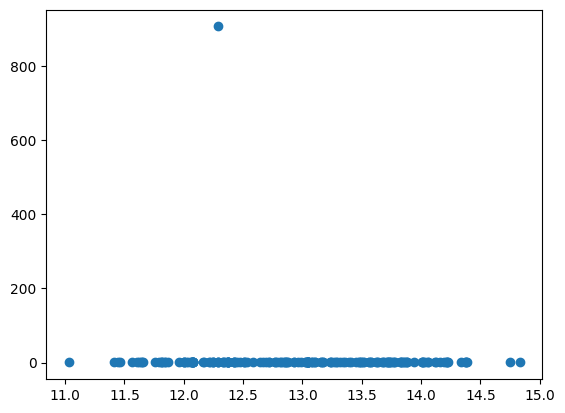

In [93]:
plt.scatter(df['Alkohol'], df['Farbwert'])
plt.show()

In [94]:
farbwert = df['Farbwert']
mask = abs((farbwert - np.mean(farbwert)) / np.std(farbwert)) > threshold
rows_to_drop = df[mask].index
df.drop(rows_to_drop, inplace=True)
df.shape

(177, 13)

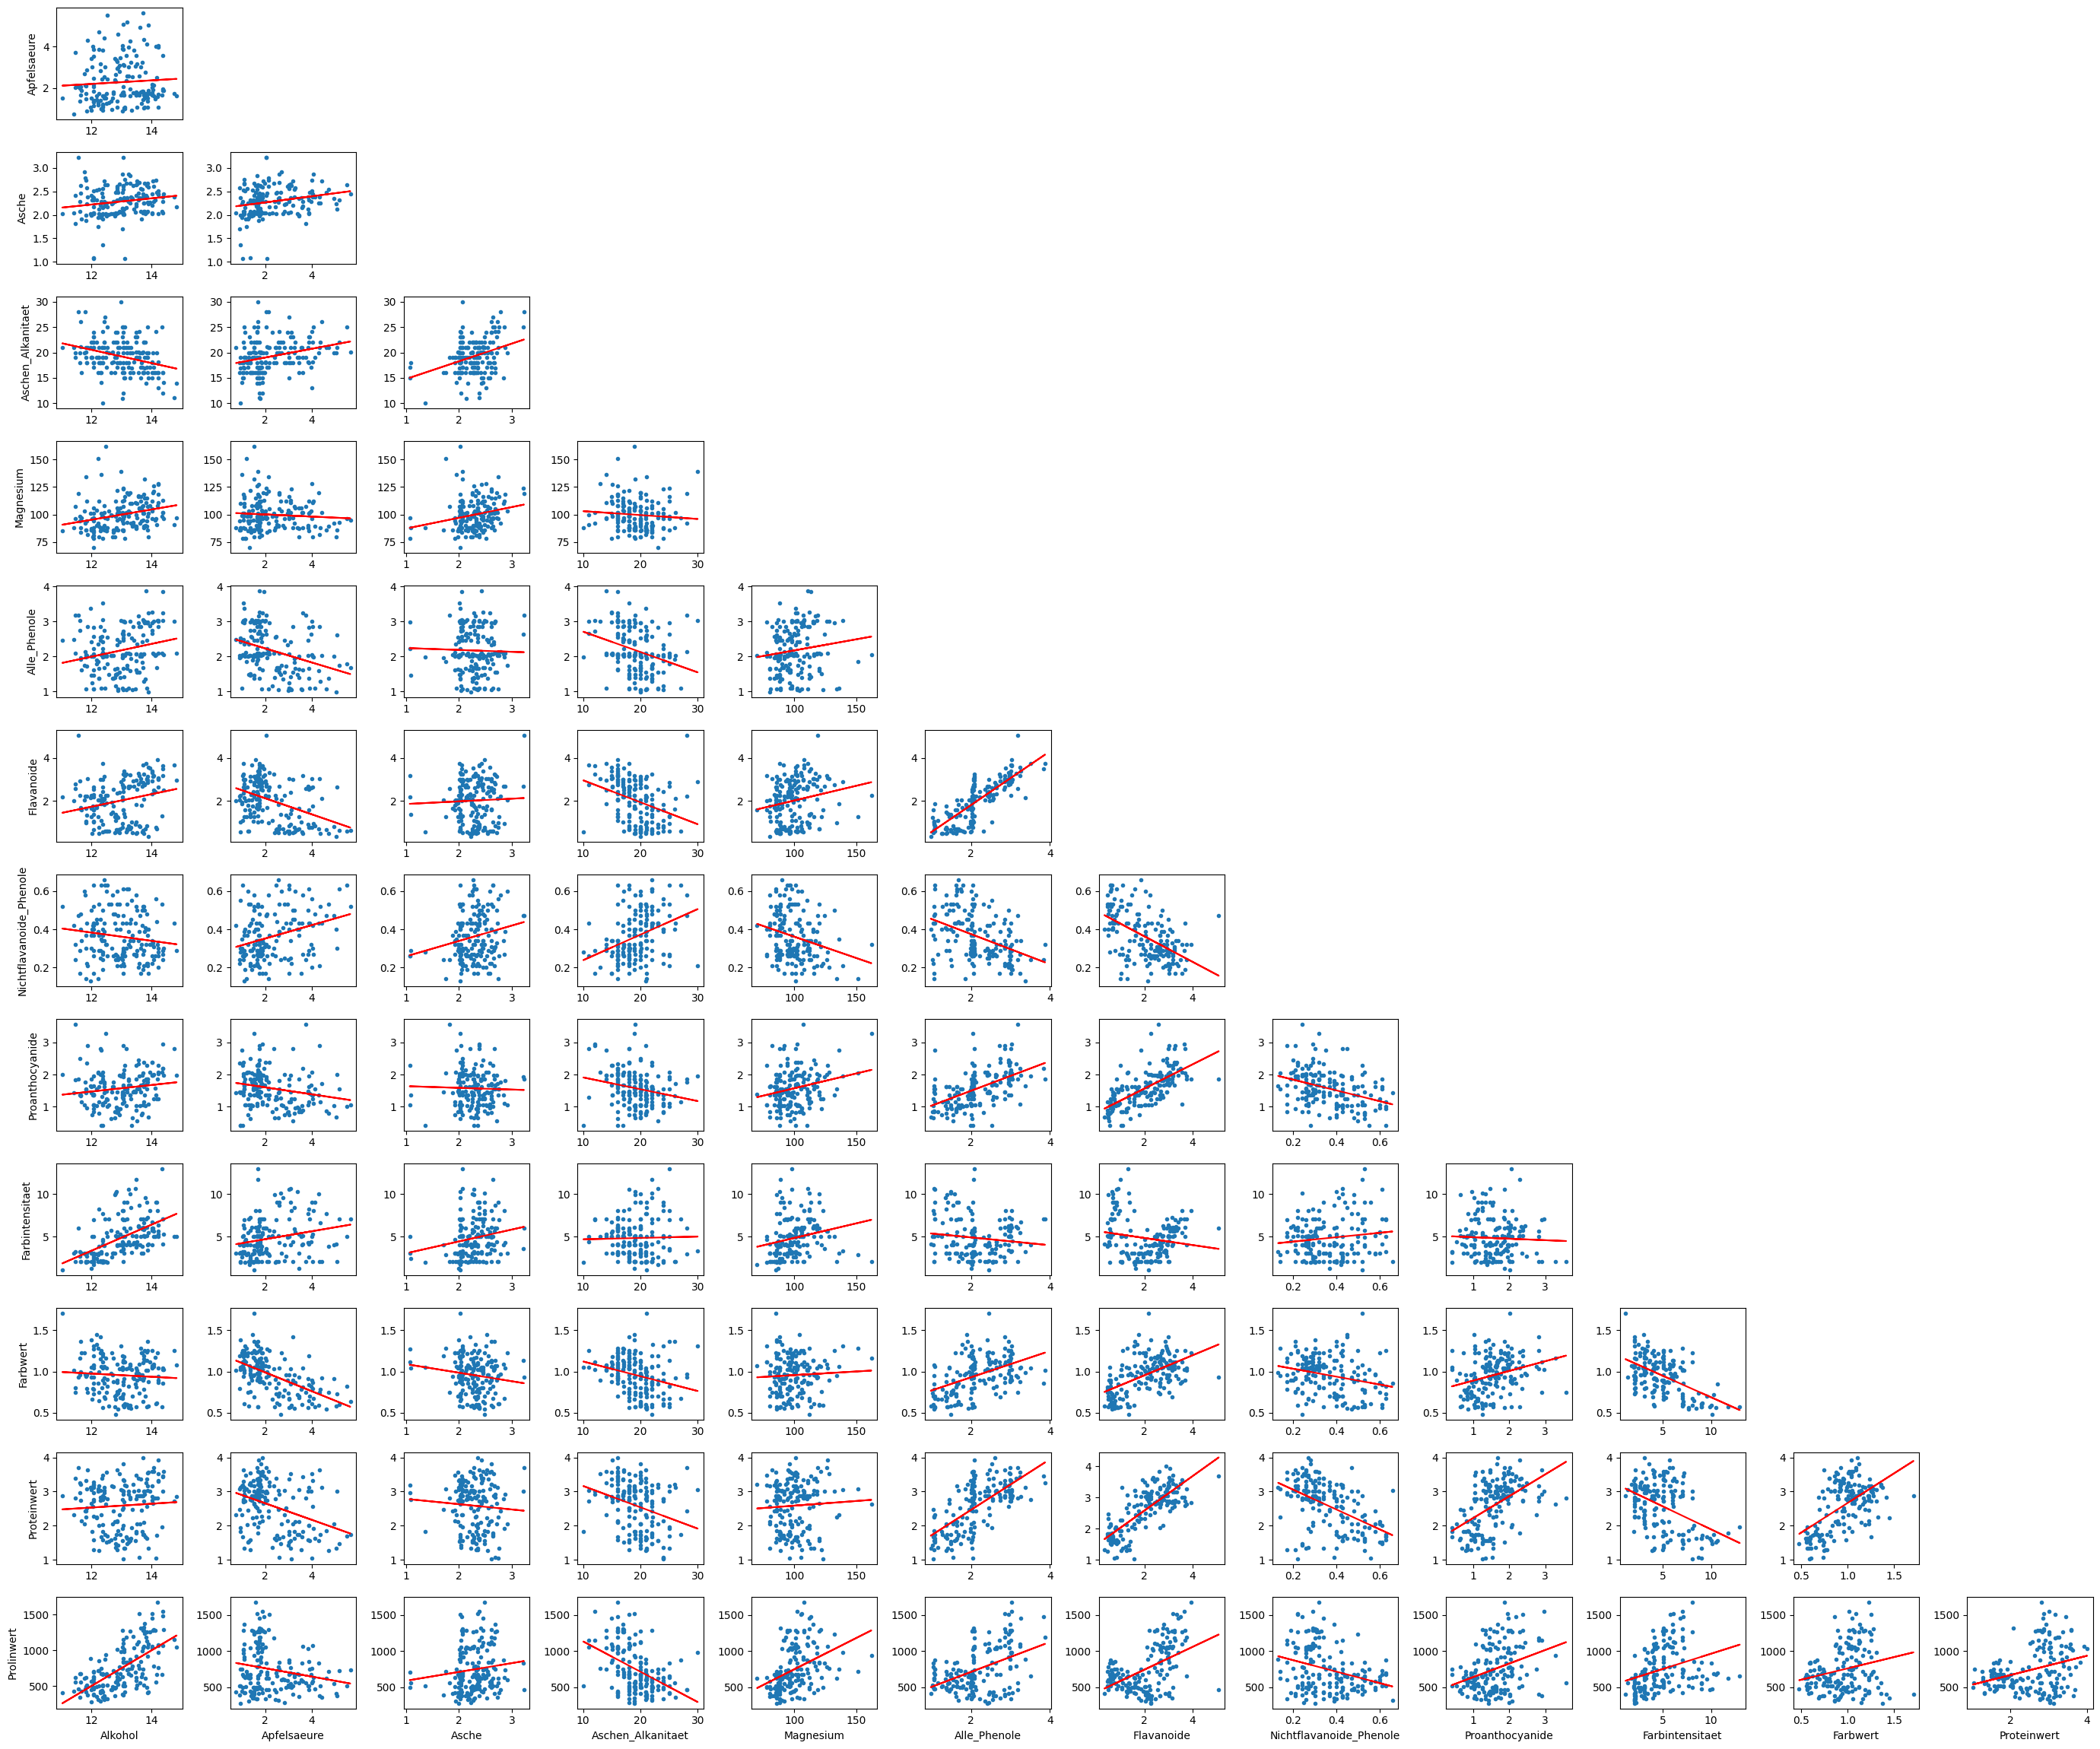

In [95]:
scores = {}
fig, axes = plt.subplots(nrows=len(df.columns), ncols=len(df.columns), figsize=(30, 25))

for i, col1 in enumerate(df.columns):
    for j, col2 in enumerate(df.columns):
        if i > j:
            X = np.array(df[col2])
            y = np.array(df[col1])
            X = np.reshape(X, (-1, 1))

            regr = LinearRegression()
            regr.fit(X, y)

            scores[(col2, col1)] = regr.score(X, y)

            axes[i, j].scatter(X, y, marker='.')
            axes[i, j].plot(X, regr.predict(X), 'r')
            
            # Set labels only on the left and bottom edges
            if i == len(df.columns) - 1:
                axes[i, j].set_xlabel(col2)
            if j == 0:
                axes[i, j].set_ylabel(col1)
        else:
            # Hide the upper-right and diagonal subplots
            axes[i, j].set_visible(False)

plt.tight_layout()

plt.show()

In [96]:
scores

{('Alkohol', 'Apfelsaeure'): 0.003988373770667297,
 ('Alkohol', 'Asche'): 0.028112037177409843,
 ('Apfelsaeure', 'Asche'): 0.05088885380699859,
 ('Alkohol', 'Aschen_Alkanitaet'): 0.09948754727178832,
 ('Apfelsaeure', 'Aschen_Alkanitaet'): 0.08024032889680055,
 ('Asche', 'Aschen_Alkanitaet'): 0.10952139665161387,
 ('Alkohol', 'Magnesium'): 0.06990304700364602,
 ('Apfelsaeure', 'Magnesium'): 0.005628097014144351,
 ('Asche', 'Magnesium'): 0.04760015261219974,
 ('Aschen_Alkanitaet', 'Magnesium'): 0.0069663520488694175,
 ('Alkohol', 'Alle_Phenole'): 0.05177738971936052,
 ('Apfelsaeure', 'Alle_Phenole'): 0.11593200665244052,
 ('Asche', 'Alle_Phenole'): 0.0006932205438346939,
 ('Aschen_Alkanitaet', 'Alle_Phenole'): 0.09014376993802609,
 ('Magnesium', 'Alle_Phenole'): 0.019423698072510764,
 ('Alkohol', 'Flavanoide'): 0.05694240793654215,
 ('Apfelsaeure', 'Flavanoide'): 0.1731500393374107,
 ('Asche', 'Flavanoide'): 0.0015940612727874948,
 ('Aschen_Alkanitaet', 'Flavanoide'): 0.11995104434315296

In [97]:
scores_values = [score for score in scores.values()]
print([{k: v} for k, v in scores.items() if v == max(scores_values)])

[{('Alle_Phenole', 'Flavanoide'): 0.6733509988219473}]


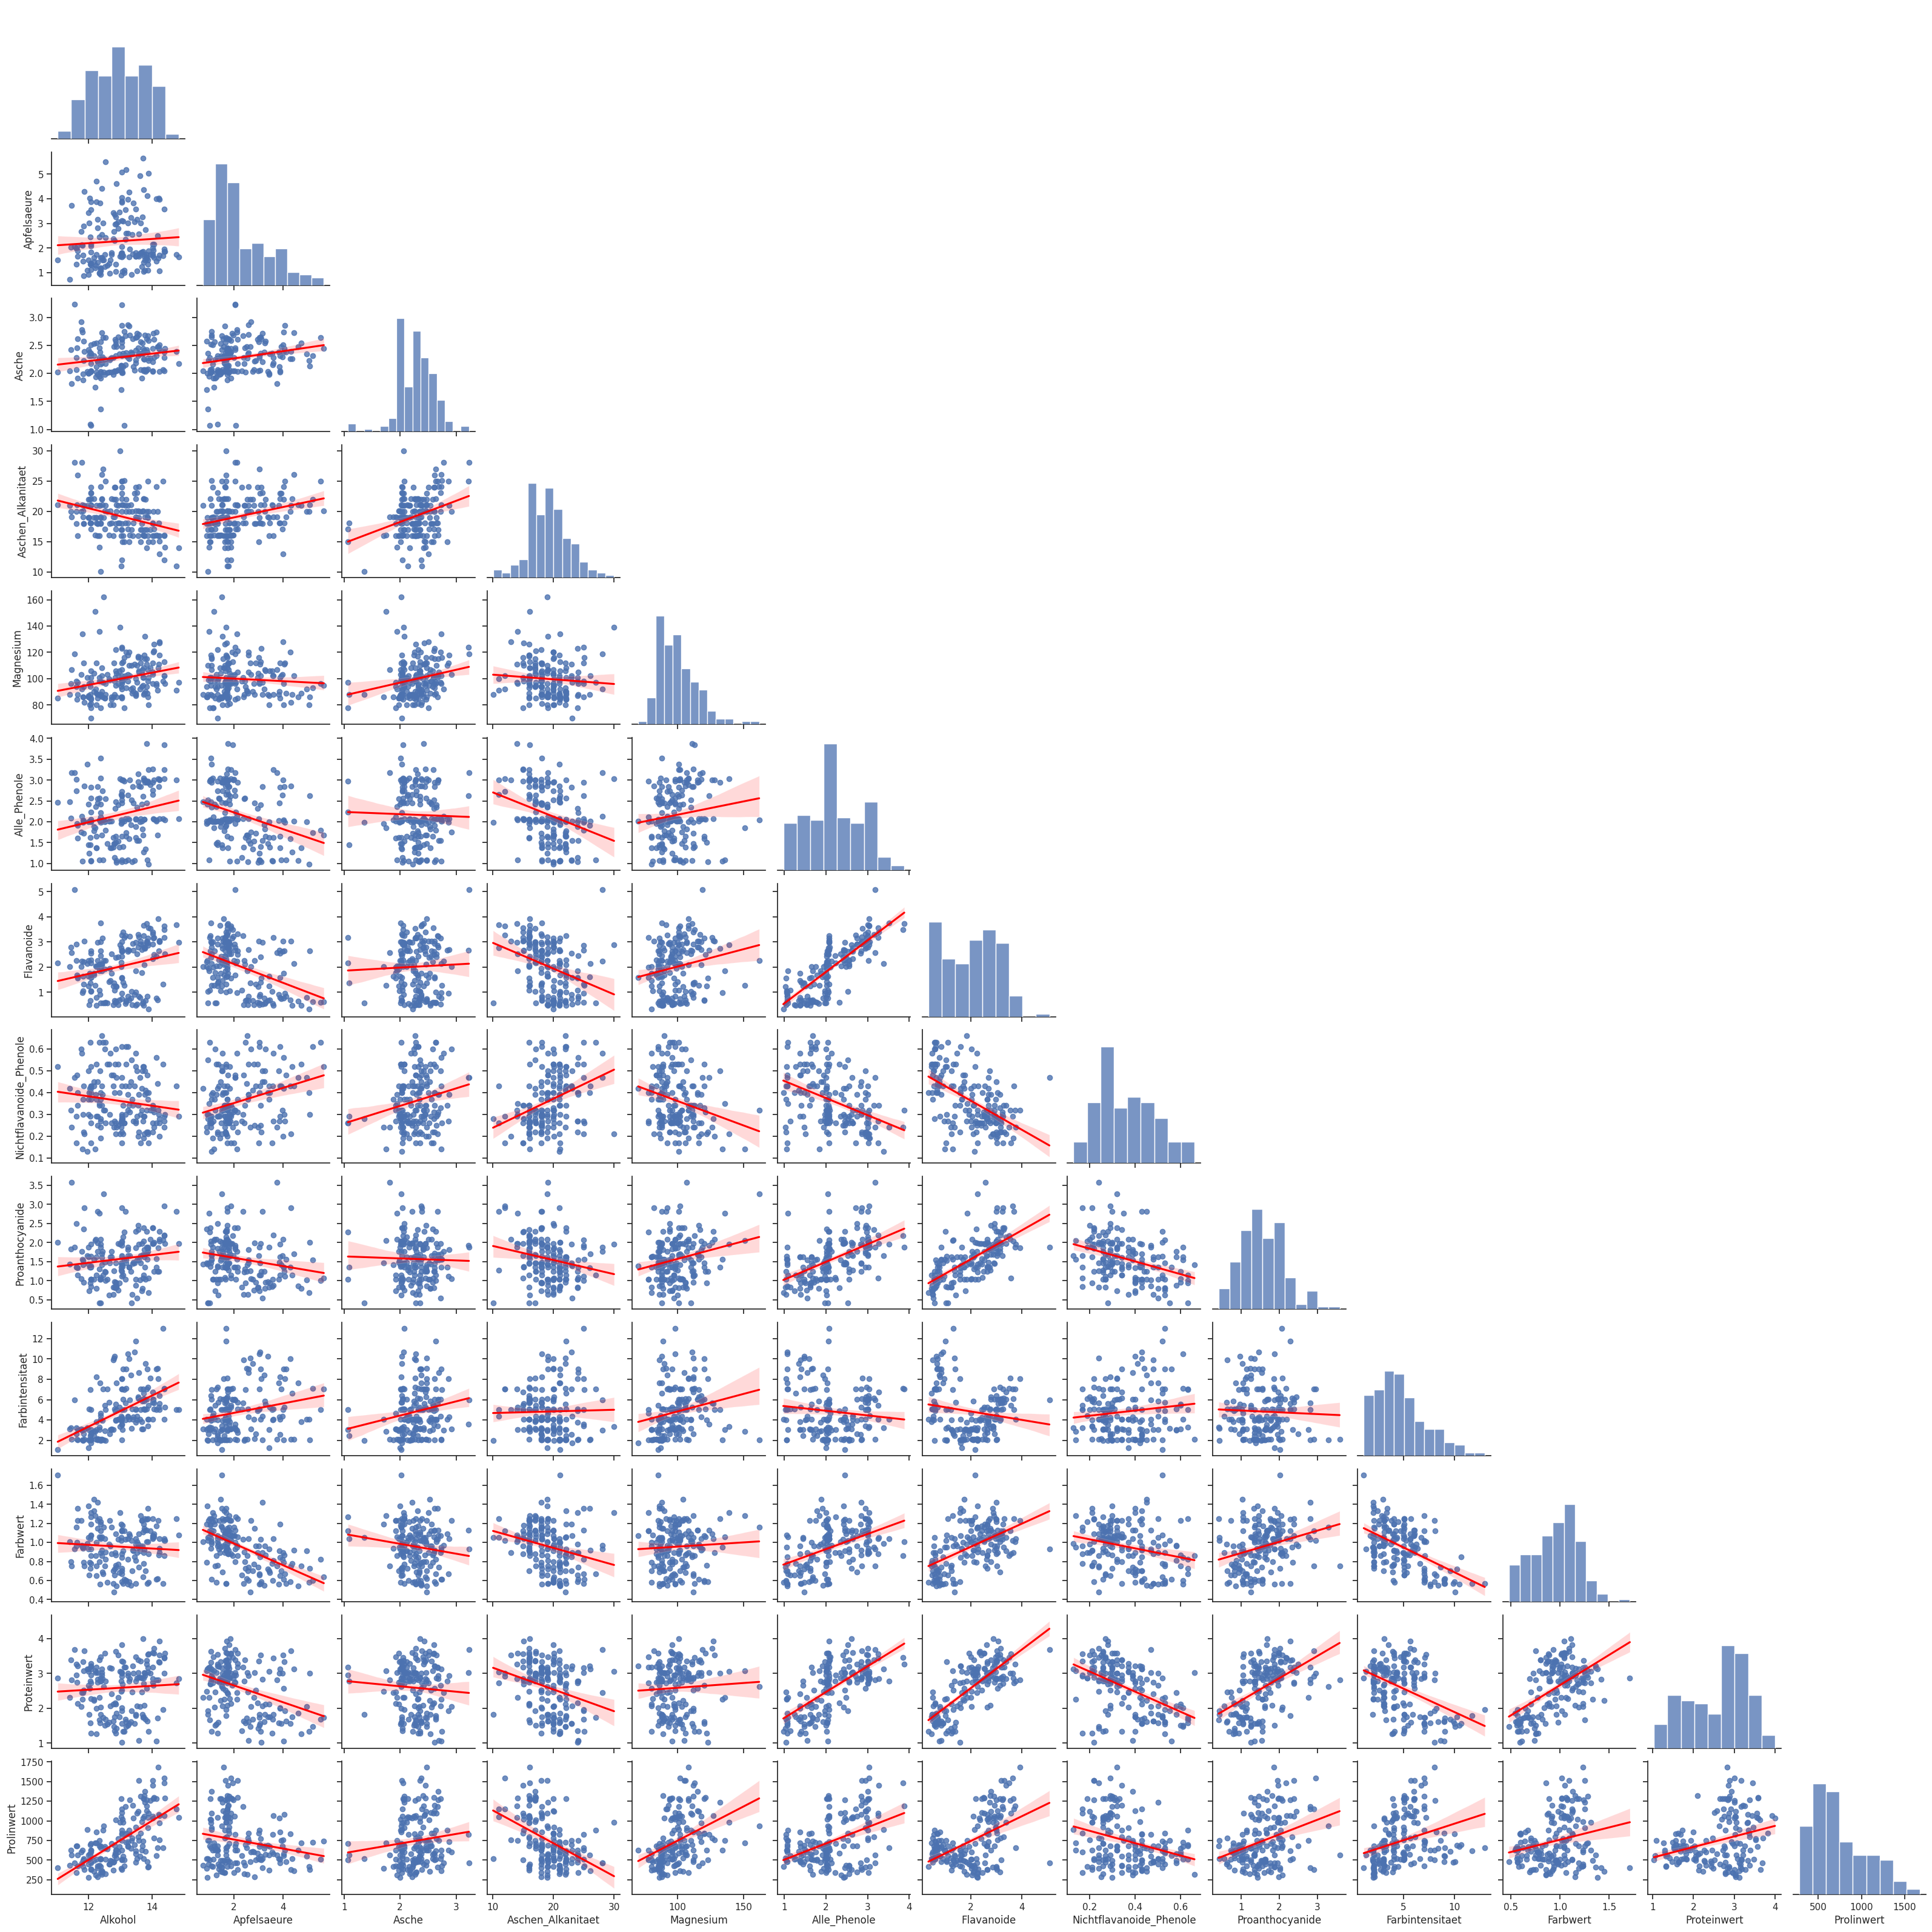

In [99]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)
sns.pairplot(data=df, kind="reg", corner=True, plot_kws={'line_kws':{'color':'red'}})